<a href="https://colab.research.google.com/github/klein-mask/signate/blob/main/competitions/no_431/n_431.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is HIROSHIMA SANDBOX Lemon competition.

## 1. Google drive init setup.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/ml/signate/no_431'

/content/drive/MyDrive/ml/signate/no_431


In [4]:
# !unzip 'train_images.zip'

In [ ]:
!unzip 'test_images.zip'

## 2. Read train data and load images. 

In [3]:
import pandas as pd

train = pd.read_csv('train_images.csv')
train['class_num'] = train['class_num'].astype('str')

In [4]:
train.shape

(1102, 2)

In [5]:
# from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

image_path = './train_images'
batch_size = 16
input_size = (300, 300)

datagen = ImageDataGenerator(
    validation_split = 0.1,
    rotation_range = 360,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range=0.1,
    zoom_range=[0.5,1.0],
    horizontal_flip = True,
    vertical_flip = True,
    rescale=None,
    preprocessing_function=None

)

train_datagen = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_path,
    x_col='id',
    y_col='class_num',
    batch_size=batch_size,
    target_size=input_size,
    class_mode='sparse',
    subset='training'
)

valid_datagen = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_path,
    x_col='id',
    y_col='class_num',
    batch_size=batch_size,
    target_size=input_size,
    class_mode='sparse',
    subset='validation'
)


Found 992 validated image filenames belonging to 4 classes.
Found 110 validated image filenames belonging to 4 classes.


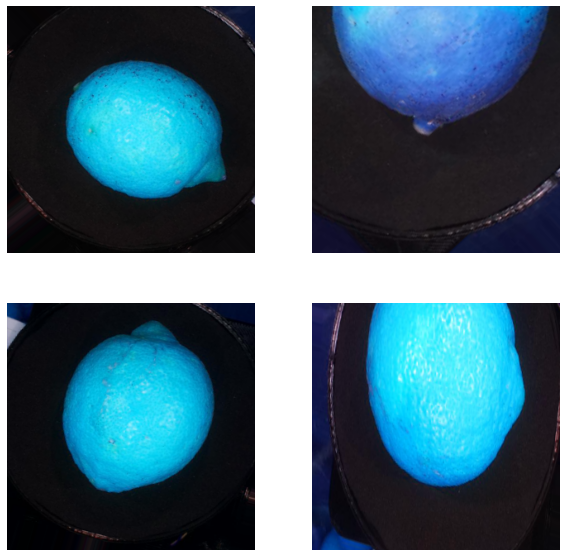

In [6]:
import numpy as np

plt.figure(figsize=(10, 10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    batch = train_datagen.next()
    image = batch[0].astype('uint8')
    plt.imshow(np.array(image[0, :, :, ::-1]))
    plt.axis('off')
plt.show()

In [7]:
from tensorflow.keras.applications import EfficientNetB3
from keras import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Activation, Dense

num_classes = len(train['class_num'].unique())
model = Sequential()
model.add(EfficientNetB3(include_top=False, weights='imagenet', input_shape=(*input_size, 3)))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 10,789,683
Trainable params: 10,702,380
Non-trainable params: 87,303
_________________________________________________________________


In [8]:
from keras.optimizers import Adam
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy'])

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

is_saved_model = True
saved_model_path = 'saved_model/best_model_efficientnetb3.h5'

def fit_model():
    model_checkpoint = ModelCheckpoint(
        filepath=saved_model_path,
        save_weight_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3
    )

    n_epochs = 20

    history = model.fit(
        train_datagen,
        validation_data=valid_datagen,
        epochs=n_epochs,
        callbacks=[model_checkpoint, early_stopping]
    )

if is_saved_model:
    model.load_weights(saved_model_path)
else:
    fit_model()

In [13]:
loss, acc = model.evaluate(valid_datagen)
print(loss, acc)

7/7 [==============================] - 3s 392ms/step - loss: 0.0253 - accuracy: 0.9818
0.025270981714129448 0.9818181991577148


In [16]:
test = pd.read_csv('test_images.csv')

In [37]:
from PIL import Image

test_pred = []
for id in test['id']:
    image = Image.open(f'test_images/{id}').resize(input_size)
    image = np.array(image).reshape(-1, 300, 300, 3)
    pred = np.argmax(model.predict(image))
    test_pred.append(pred)

In [40]:
test_pred[:5]

[0, 3, 0, 3, 0]

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1651 entries, 0 to 1650
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1651 non-null   object
dtypes: object(1)
memory usage: 13.0+ KB


In [42]:
test['class_num'] = test_pred

In [43]:
test.to_csv('submit_001.csv', header=False, index=False)